데이터 전처리

In [1]:
import pandas as pd

# 파일 경로 설정
file1_path = r"C:\Users\m\Downloads\서울시_상권분석_서비스_컬럼제거.csv"
file2_path = r"C:\Users\m\Downloads\[상권성장지수]증감률통합(서울평균까지).csv"
output_path = r"C:\Users\m\Downloads\서울시_상권분석_서비스_결과.csv"

# 데이터 불러오기
df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# 컬럼명 통일 (연분기 ↔ 기준_년분기_코드, 상권명 ↔ 상권_코드_명)
df_merged = df1.merge(df2[['기준_년분기_코드', '상권_코드_명', '당월_매출_금액_증감률']],
                      left_on=['연분기', '상권명'],
                      right_on=['기준_년분기_코드', '상권_코드_명'],
                      how='left')

# 불필요한 컬럼 삭제
df_merged.drop(columns=['기준_년분기_코드', '상권_코드_명'], inplace=True)

# 상권성장상태 컬럼 생성
def classify_growth(rate):
    if rate >= 5:
        return "성장"
    elif rate <= -5:
        return "쇠퇴"
    else:
        return "정체"

df_merged['상권성장상태'] = df_merged['당월_매출_금액_증감률'].apply(classify_growth)

# 결과 저장
df_merged.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"처리 완료: {output_path}")

처리 완료: C:\Users\m\Downloads\서울시_상권분석_서비스_결과.csv


In [2]:
import pandas as pd

# 파일 경로 설정
file_path = r"C:\Users\m\Downloads\서울시_상권분석_서비스_결과.csv"
output_path = r"C:\Users\m\Downloads\서울시_상권분석_서비스_결과_수정.csv"

# 데이터 불러오기
df = pd.read_csv(file_path)

# '연분기' 값이 20191인 행 제거
df_filtered = df[df['연분기'] != 20191]

# 수정된 데이터 저장
df_filtered.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"처리 완료: {output_path}")

처리 완료: C:\Users\m\Downloads\서울시_상권분석_서비스_결과_수정.csv


In [3]:
import pandas as pd

# 파일 경로 설정
file_path = r"C:\Users\m\Downloads\서울시_상권분석_서비스_결과_수정.csv"
output_path = r"C:\Users\m\Downloads\서울시_상권분석_서비스_결과_최종.csv"

# 데이터 불러오기
df = pd.read_csv(file_path)

# '당월_매출_금액_증감률' 컬럼의 값이 NaN인 행 제거
df_cleaned = df.dropna(subset=['당월_매출_금액_증감률'])

# 수정된 데이터 저장
df_cleaned.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"처리 완료: {output_path}")

처리 완료: C:\Users\m\Downloads\서울시_상권분석_서비스_결과_최종.csv


안정성 관련 변수 생성 및 정의.

In [5]:
import pandas as pd

# 데이터 불러오기
file_path = r"C:\Users\m\Downloads\매출-안정성 데이터.csv"
df = pd.read_csv(file_path)

# ✅ 안정성 변수 정의
df["개폐업_비율"] = df["폐업_점포_수"] / (df["개업_점포_수"] + 1)  
df["영업_개월_차이"] = df["운영_영업_개월_평균"] - df["폐업_영업_개월_평균"]
df["프랜차이즈_비율"] = df["프랜차이즈_점포_수"] / df["점포_수"]
df["점포_증감률"] = (df["점포_수"] - df["점포_수"].shift(1)) / df["점포_수"].shift(1) * 100

# ✅ 성장, 쇠퇴 상권에서 안정성 변수들의 최솟값/최댓값 찾기
growth_min = df[df["상권성장상태"] == "성장"][["개폐업_비율", "영업_개월_차이", "프랜차이즈_비율", "점포_증감률"]].min()
decline_max = df[df["상권성장상태"] == "쇠퇴"][["개폐업_비율", "영업_개월_차이", "프랜차이즈_비율", "점포_증감률"]].max()

# ✅ 상권 안정성 분류 함수
def classify_stability(row):
    if (row["개폐업_비율"] >= decline_max["개폐업_비율"]) or \
       (row["영업_개월_차이"] <= decline_max["영업_개월_차이"]) or \
       (row["프랜차이즈_비율"] <= decline_max["프랜차이즈_비율"]) or \
       (row["점포_증감률"] <= decline_max["점포_증감률"]):
        return "불안정"

    elif (row["개폐업_비율"] <= growth_min["개폐업_비율"]) and \
         (row["영업_개월_차이"] >= growth_min["영업_개월_차이"]) and \
         (row["프랜차이즈_비율"] >= growth_min["프랜차이즈_비율"]) and \
         (row["점포_증감률"] >= growth_min["점포_증감률"]):
        return "안정"

    else:
        return "중립"

# ✅ 상권 안정성 분류 적용
df["상권_안정성"] = df.apply(classify_stability, axis=1)

# ✅ 결과 저장
output_path = r"C:\Users\m\Downloads\매출-안정성 데이터_분류.csv"
df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"처리 완료: {output_path}")

처리 완료: C:\Users\m\Downloads\매출-안정성 데이터_분류.csv


In [7]:
import pandas as pd

# 데이터 로드
df = pd.read_csv(r"C:\Users\m\Downloads\매출-안정성 데이터.csv")

# ✅ 안정성 변수 정의 (최근 4개 분기 평균 이용)
df["개폐업_비율"] = df.groupby(["상권명", "업종명"])['폐업_점포_수'].transform(lambda x: x.rolling(4, min_periods=1).mean()) / (df.groupby(["상권명", "업종명"])['개업_점포_수'].transform(lambda x: x.rolling(4, min_periods=1).mean()) + 1)
df["영업_개월_차이"] = df.groupby(["상권명", "업종명"])['운영_영업_개월_평균'].transform(lambda x: x.rolling(4, min_periods=1).mean()) - df.groupby(["상권명", "업종명"])['폐업_영업_개월_평균'].transform(lambda x: x.rolling(4, min_periods=1).mean())
df["프랜차이즈_비율"] = df.groupby(["상권명", "업종명"])['프랜차이즈_점포_수'].transform(lambda x: x.rolling(4, min_periods=1).mean()) / df.groupby(["상권명", "업종명"])['점포_수'].transform(lambda x: x.rolling(4, min_periods=1).mean())
df["점포_증감률"] = (df.groupby(["상권명", "업종명"])['점포_수'].transform(lambda x: x.rolling(4, min_periods=1).mean()).diff()) / df.groupby(["상권명", "업종명"])['점포_수'].transform(lambda x: x.rolling(4, min_periods=1).mean()).shift(1) * 100

# ✅ 안정성 지표 범위 설정 (상권성장상태 기반)
성장_최솟값 = df[df["상권성장상태"] == "성장"][["개폐업_비율", "영업_개월_차이", "프랜차이즈_비율", "점포_증감률"]].min()
쇠퇴_최댓값 = df[df["상권성장상태"] == "쇠퇴"][["개폐업_비율", "영업_개월_차이", "프랜차이즈_비율", "점포_증감률"]].max()

# ✅ 안정성 지표에 따라 성장, 정체, 쇠퇴 재분류
def classify_growth(row):
    if (row["개폐업_비율"] >= 쇠퇴_최댓값["개폐업_비율"]) or \
       (row["영업_개월_차이"] <= 쇠퇴_최댓값["영업_개월_차이"]) or \
       (row["프랜차이즈_비율"] <= 쇠퇴_최댓값["프랜차이즈_비율"]) or \
       (row["점포_증감률"] <= 쇠퇴_최댓값["점포_증감률"]):
        return "쇠퇴"
    elif (row["개폐업_비율"] <= 성장_최솟값["개폐업_비율"]) and \
         (row["영업_개월_차이"] >= 성장_최솟값["영업_개월_차이"]) and \
         (row["프랜차이즈_비율"] >= 성장_최솟값["프랜차이즈_비율"]) and \
         (row["점포_증감률"] >= 성장_최솟값["점포_증감률"]):
        return "성장"
    else:
        return "정체"

df["재분류_상권성장상태"] = df.apply(classify_growth, axis=1)

# ✅ 결과 저장
df.to_csv(r"C:\Users\m\Downloads\매출-안정성 데이터_처리완료.csv", index=False)

In [8]:
import pandas as pd

# 데이터 불러오기
file_path = r"C:\Users\m\Downloads\매출-안정성 데이터.csv"
df = pd.read_csv(file_path)

# ✅ 안정성 변수 정의 (최근 4개 분기 평균 이용)
df["개폐업_비율"] = df.groupby(["상권명", "업종명"])['폐업_점포_수'].transform(lambda x: x.rolling(4, min_periods=1).mean()) / (df.groupby(["상권명", "업종명"])['개업_점포_수'].transform(lambda x: x.rolling(4, min_periods=1).mean()) + 1)
df["영업_개월_차이"] = df.groupby(["상권명", "업종명"])['운영_영업_개월_평균'].transform(lambda x: x.rolling(4, min_periods=1).mean()) - df.groupby(["상권명", "업종명"])['폐업_영업_개월_평균'].transform(lambda x: x.rolling(4, min_periods=1).mean())
df["프랜차이즈_비율"] = df.groupby(["상권명", "업종명"])['프랜차이즈_점포_수'].transform(lambda x: x.rolling(4, min_periods=1).mean()) / df.groupby(["상권명", "업종명"])['점포_수'].transform(lambda x: x.rolling(4, min_periods=1).mean())
df["점포_증감률"] = (df.groupby(["상권명", "업종명"])['점포_수'].transform(lambda x: x.rolling(4, min_periods=1).mean()).diff()) / df.groupby(["상권명", "업종명"])['점포_수'].transform(lambda x: x.rolling(4, min_periods=1).mean()).shift(1) * 100

# 데이터 저장
output_path = r"C:\Users\m\Downloads\매출-안정성_계산완료.csv"
df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"파일 저장 완료: {output_path}")

파일 저장 완료: C:\Users\m\Downloads\매출-안정성_계산완료.csv


상관관계 분석

In [9]:
import pandas as pd

# 데이터 불러오기
file_path = r"C:\Users\m\Downloads\매출-안정성_계산완료.csv"
df = pd.read_csv(file_path)

# ✅ 20241 데이터 필터링
df_20241 = df[df["연분기"] == 20241]

# ✅ 상관관계 분석 대상 컬럼 선택
correlation_columns = ["개폐업_비율", "영업_개월_차이", "프랜차이즈_비율", "점포_증감률", "당월_매출_금액_증감률"]

# ✅ 해당 컬럼들 간의 상관관계 계산
correlation_matrix = df_20241[correlation_columns].corr()

# ✅ 결과 출력
print(correlation_matrix)

                개폐업_비율  영업_개월_차이  프랜차이즈_비율    점포_증감률  당월_매출_금액_증감률
개폐업_비율        1.000000 -0.083057  0.067180  0.270814     -0.009518
영업_개월_차이     -0.083057  1.000000 -0.015176 -0.013317     -0.039737
프랜차이즈_비율      0.067180 -0.015176  1.000000 -0.009188     -0.003199
점포_증감률        0.270814 -0.013317 -0.009188  1.000000     -0.004570
당월_매출_금액_증감률 -0.009518 -0.039737 -0.003199 -0.004570      1.000000


In [10]:
import pandas as pd

# 데이터 불러오기
file_path = r"C:\Users\m\Downloads\매출-안정성_계산완료.csv"
df = pd.read_csv(file_path)

# ✅ 상관관계 분석 대상 컬럼 선택
correlation_columns = ["개폐업_비율", "영업_개월_차이", "프랜차이즈_비율", "점포_증감률", "당월_매출_금액_증감률"]

# ✅ 상권별 상관관계 계산
correlation_results = {}

for 상권명, group in df.groupby("상권명"):
    correlation_matrix = group[correlation_columns].corr()
    correlation_results[상권명] = correlation_matrix["당월_매출_금액_증감률"].drop("당월_매출_금액_증감률")

# ✅ 결과 출력
for 상권명, correlation in correlation_results.items():
    print(f"\n📍 {상권명} 상권의 상관관계")
    print(correlation)


📍 4.19민주묘지역 2번 상권의 상관관계
개폐업_비율      0.051768
영업_개월_차이    0.011692
프랜차이즈_비율    0.009847
점포_증감률     -0.014310
Name: 당월_매출_금액_증감률, dtype: float64

📍 63빌딩 상권의 상관관계
개폐업_비율     -0.014457
영업_개월_차이    0.053988
프랜차이즈_비율    0.003077
점포_증감률      0.048371
Name: 당월_매출_금액_증감률, dtype: float64

📍 DMC(디지털미디어시티) 상권의 상관관계
개폐업_비율      0.014385
영업_개월_차이   -0.068286
프랜차이즈_비율    0.003697
점포_증감률     -0.021161
Name: 당월_매출_금액_증감률, dtype: float64

📍 GS강동자이아파트 상권의 상관관계
개폐업_비율     -0.032471
영업_개월_차이   -0.268431
프랜차이즈_비율   -0.006490
점포_증감률     -0.022350
Name: 당월_매출_금액_증감률, dtype: float64

📍 G타워 상권의 상관관계
개폐업_비율      0.029970
영업_개월_차이    0.203695
프랜차이즈_비율    0.004721
점포_증감률     -0.023318
Name: 당월_매출_금액_증감률, dtype: float64

📍 KB국민은행 망원동지점 상권의 상관관계
개폐업_비율     -0.019281
영업_개월_차이    0.049214
프랜차이즈_비율   -0.010944
점포_증감률      0.006777
Name: 당월_매출_금액_증감률, dtype: float64

📍 KB국민은행 서강지점 상권의 상관관계
개폐업_비율      0.015590
영업_개월_차이   -0.065024
프랜차이즈_비율   -0.036183
점포_증감률     -0.010400
Name: 당월_매출_금액_증감률, dtype: float64

📍 KB국민은행 종암

In [11]:
import pandas as pd

# 데이터 불러오기
file_path = r"C:\Users\m\Downloads\매출-안정성_계산완료.csv"
df = pd.read_csv(file_path)

# ✅ 20242 분기 데이터 필터링
df_20242 = df[df["연분기"] == 20242]

# ✅ 상관관계 분석 대상 컬럼 선택
correlation_columns = ["개폐업_비율", "영업_개월_차이", "프랜차이즈_비율", "점포_증감률", "당월_매출_금액_증감률"]

# ✅ 상권별 상관관계 계산
correlation_results = []

for 상권명, group in df_20242.groupby("상권명"):
    correlation_matrix = group[correlation_columns].corr()
    correlation_values = correlation_matrix["당월_매출_금액_증감률"].drop("당월_매출_금액_증감률")
    correlation_results.append(correlation_values)

# ✅ 상관계수 평균 계산
correlation_mean = pd.DataFrame(correlation_results).mean()

# ✅ 결과 출력
print("\n📌 20242 분기 상권별 상관관계의 평균")
print(correlation_mean)


📌 20242 분기 상권별 상관관계의 평균
개폐업_비율     NaN
영업_개월_차이   NaN
프랜차이즈_비율   NaN
점포_증감률     NaN
dtype: float64


In [16]:
import pandas as pd

# 데이터 불러오기
file_path = r"C:\Users\m\Downloads\매출-안정성_계산완료.csv"
df = pd.read_csv(file_path)

# ✅ 컬럼명 확인 및 공백 제거
df.columns = df.columns.str.strip()  # 혹시 모를 공백 제거
print("🔍 데이터 컬럼명 확인:", df.columns)

# ✅ 20242 분기 데이터 필터링
df_20242 = df[df["연분기"] == 20242]

# ✅ 1. 컬럼명 공백 제거
df_20242.rename(columns=lambda x: x.strip(), inplace=True)

# ✅ 2. 숫자로 변환 가능한 컬럼만 선택
numeric_columns = df_20242.select_dtypes(include=["number"]).columns
df_20242 = df_20242[numeric_columns]

# ✅ 3. 상관관계 계산 (수정된 코드)
def calculate_corr(group):
    if len(group) > 1:
        corr_matrix = group.corr()
        if "당월_매출_금액_증감률" in corr_matrix:
            return corr_matrix.loc["당월_매출_금액_증감률"].drop("당월_매출_금액_증감률", errors="ignore")
    return pd.Series(index=numeric_columns[:-1], dtype="float64")  # 빈 값 반환

correlation_results = df_20242.groupby("상권명").apply(calculate_corr)

# ✅ 4. NaN 값 제외 후 평균 계산
correlation_mean = correlation_results.mean(skipna=True)

# 결과 출력
print("\n📌 20242 분기 상권별 상관관계의 평균")
print(correlation_mean)

🔍 데이터 컬럼명 확인: Index(['연분기', '상권명', '업종명', '점포_수', '유사_업종_점포_수', '개업율', '개업_점포_수', '폐업률',
       '폐업_점포_수', '프랜차이즈_점포_수', '자치구명', '운영_영업_개월_평균', '폐업_영업_개월_평균',
       '당월_매출_금액_증감률', '상권성장상태', '개폐업_비율', '영업_개월_차이', '프랜차이즈_비율', '점포_증감률'],
      dtype='object')


C:\Users\m\AppData\Local\Temp\ipykernel_20176\2973739088.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_20242.rename(columns=lambda x: x.strip(), inplace=True)


KeyError: '상권명'

다시 전처리

In [17]:
import pandas as pd

# ✅ 데이터 불러오기
file_path = "C:\\Users\\m\\Downloads\\매출-안정성 데이터.csv"
df = pd.read_csv(file_path)

# ✅ 📌 1. 개폐업 변화량 (개업 - 폐업)
df["개폐업_변화량"] = df["개업_점포_수"] - df["폐업_점포_수"]

# ✅ 📌 2. 영업 지속 기간 차이 (운영 영업 개월 - 폐업 영업 개월)
df["영업_지속_기간_차이"] = df["운영_영업_개월_평균"] - df["폐업_영업_개월_평균"]

# ✅ 📌 3. 점포 증감량 (현재 점포 수 - 유사 업종 점포 수)
df["점포_증감량"] = df["점포_수"] - df["유사_업종_점포_수"]

# ✅ 📌 4. 프랜차이즈 안정성 점수 (25:50:25 비율 적용)
q1 = df["프랜차이즈_점포_수"].quantile(0.25)  # 하위 25% (Q1)
q2 = df["프랜차이즈_점포_수"].quantile(0.75)  # 상위 25% (Q3)

def franchise_stability_score(franchise_count):
    if franchise_count == 0:
        return 0  # 프랜차이즈 없음
    elif franchise_count <= q1:
        return 1  # 하위 25%
    elif franchise_count <= q2:
        return 2  # 중간 50%
    else:
        return 3  # 상위 25%

df["프랜차이즈_안정성_점수"] = df["프랜차이즈_점포_수"].apply(franchise_stability_score)

# ✅ 📌 5. 불필요한 컬럼 제거 (겹치는 정보)
drop_columns = [
    "개업_점포_수", "폐업_점포_수", "운영_영업_개월_평균", "폐업_영업_개월_평균", 
    "점포_수", "유사_업종_점포_수", "프랜차이즈_점포_수"
]
df.drop(columns=drop_columns, inplace=True)

# ✅ 새로운 데이터 저장
output_path = "C:\\Users\\m\\Downloads\\매출-안정성 데이터_추가.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

# ✅ 처리 완료 메시지
print(f"새로운 데이터 저장 완료: {output_path}")

새로운 데이터 저장 완료: C:\Users\m\Downloads\매출-안정성 데이터_추가.csv


In [18]:
import pandas as pd

# ✅ 데이터 불러오기
file_path = "C:\\Users\\m\\Downloads\\매출-안정성 데이터.csv"
df = pd.read_csv(file_path)

# ✅ 📌 1. 개폐업 변화량 (개업 - 폐업)
df["개폐업_변화량"] = df["개업_점포_수"] - df["폐업_점포_수"]

# ✅ 📌 2. 영업 지속 기간 차이 (운영 영업 개월 - 폐업 영업 개월)
df["영업_지속_기간_차이"] = df["운영_영업_개월_평균"] - df["폐업_영업_개월_평균"]

# ✅ 📌 3. 점포 증감량 (현재 점포 수 - 유사 업종 점포 수)
df["점포_증감량"] = df["점포_수"] - df["유사_업종_점포_수"]

# ✅ 📌 4. 프랜차이즈 안정성 점수 (25:50:25 비율 적용)
q1 = df["프랜차이즈_점포_수"].quantile(0.25)  # 하위 25% (Q1)
q2 = df["프랜차이즈_점포_수"].quantile(0.75)  # 상위 25% (Q3)

def franchise_stability_score(franchise_count):
    if franchise_count == 0:
        return 0  # 프랜차이즈 없음
    elif franchise_count <= q1:
        return 1  # 하위 25%
    elif franchise_count <= q2:
        return 2  # 중간 50%
    else:
        return 3  # 상위 25%

df["프랜차이즈_안정성_점수"] = df["프랜차이즈_점포_수"].apply(franchise_stability_score)

# ✅ 새로운 데이터 저장
output_path = "C:\\Users\\m\\Downloads\\매출-안정성 데이터_추가.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

# ✅ 처리 완료 메시지
print(f"새로운 데이터 저장 완료: {output_path}")

새로운 데이터 저장 완료: C:\Users\m\Downloads\매출-안정성 데이터_추가.csv


개폐업_변화량, 영업_지속_기간_차이, 점포_증감량, 프랜차이즈_안정성_점수 상관관계 계산

In [19]:
import pandas as pd

# ✅ 데이터 불러오기
file_path = "C:\\Users\\m\\Downloads\\매출-안정성 데이터_추가.csv"
df = pd.read_csv(file_path)

# ✅ 사용할 변수 목록
variables = ["개폐업_변화량", "영업_지속_기간_차이", "점포_증감량", "프랜차이즈_안정성_점수"]

# ✅ 선택한 변수들과 "당월_매출_금액_증감률" 간의 상관관계 계산
correlation_matrix = df[variables + ["당월_매출_금액_증감률"]].corr()

# ✅ "당월_매출_금액_증감률"과 관련된 부분만 추출
correlation_with_target = correlation_matrix["당월_매출_금액_증감률"].sort_values(ascending=False)

# ✅ 결과 출력
print("📌 '당월_매출_금액_증감률'과 추가 변수들의 상관관계:")
print(correlation_with_target)

📌 '당월_매출_금액_증감률'과 추가 변수들의 상관관계:
당월_매출_금액_증감률    1.000000
영업_지속_기간_차이     0.004677
점포_증감량          0.000870
개폐업_변화량        -0.000370
프랜차이즈_안정성_점수   -0.001235
Name: 당월_매출_금액_증감률, dtype: float64


In [23]:
import pandas as pd

# 📌 데이터 로드 (예제)
data = pd.DataFrame({
    "점포_수": [20, 48, 67, 20, 5],
    "유사_업종_점포_수": [20, 52, 76, 33, 5],
    "개업_점포_수": [0, 4, 1, 2, 0],
    "폐업_점포_수": [1, 0, 1, 4, 1],
    "프랜차이즈_점포_수": [0, 4, 9, 13, 0],
    "운영_영업_개월_평균": [93.0, 93.0, 93.0, 93.0, 93.0],
    "폐업_영업_개월_평균": [49.0, 49.0, 49.0, 49.0, 49.0],
})

# ✅ 개폐업 변화량 계산 (개업 점포 수 - 폐업 점포 수)
data["개폐업_변화량"] = data["개업_점포_수"] - data["폐업_점포_수"]

# ✅ 점포 증감량 계산 (현재 점포 수 - 유사 업종 점포 수)
data["점포_증감량"] = data["점포_수"] - data["유사_업종_점포_수"]

# ✅ 영업 지속 기간 차이 계산 (운영 영업 개월 평균 - 폐업 영업 개월 평균)
data["영업_지속_기간_차이"] = data["운영_영업_개월_평균"] - data["폐업_영업_개월_평균"]

# ✅ 평균 영업 지속 기간 계산 (운영 영업 개월 평균 + 폐업 영업 개월 평균) / 2
data["평균_영업_지속_기간"] = (data["운영_영업_개월_평균"] + data["폐업_영업_개월_평균"]) / 2

# ✅ 프랜차이즈 비율 계산
data["프랜차이즈_비율"] = data["프랜차이즈_점포_수"] / data["점포_수"]
data["프랜차이즈_비율"] = data["프랜차이즈_비율"].replace([float("inf"), -float("inf")], 0).fillna(0.0001)

# ✅ 분위수 확인 후 안정성 점수 부여
_, bins = pd.qcut(data["프랜차이즈_비율"], q=[0, 0.25, 0.75, 1], retbins=True, duplicates="drop")
num_bins = len(bins) - 1

if num_bins >= 3:
    data["프랜차이즈_안정성_점수"] = pd.qcut(
        data["프랜차이즈_비율"], 
        q=[0, 0.25, 0.75, 1], 
        labels=[1, 2, 3][:num_bins],  # 구간 개수에 맞게 조정
        duplicates="drop"
    ).astype(int)
else:
    data["프랜차이즈_안정성_점수"] = pd.cut(
        data["프랜차이즈_비율"], 
        bins=3, 
        labels=[1, 2, 3], 
        include_lowest=True
    ).astype(int)

# ✅ 최종 데이터 확인
print(data)

   점포_수  유사_업종_점포_수  개업_점포_수  폐업_점포_수  프랜차이즈_점포_수  운영_영업_개월_평균  폐업_영업_개월_평균  \
0    20          20        0        1           0         93.0         49.0   
1    48          52        4        0           4         93.0         49.0   
2    67          76        1        1           9         93.0         49.0   
3    20          33        2        4          13         93.0         49.0   
4     5           5        0        1           0         93.0         49.0   

   개폐업_변화량  점포_증감량  영업_지속_기간_차이  평균_영업_지속_기간  프랜차이즈_비율  프랜차이즈_안정성_점수  
0       -1       0         44.0         71.0  0.000000             1  
1        4      -4         44.0         71.0  0.083333             1  
2        0      -9         44.0         71.0  0.134328             1  
3       -2     -13         44.0         71.0  0.650000             3  
4       -1       0         44.0         71.0  0.000000             1  


In [41]:
import pandas as pd

# ✅ 1. 데이터 불러오기
df = pd.read_csv(r"C:\Users\m\Downloads\매출-안정성 데이터_추가.csv")

# ✅ 2. 2024년 2분기(20242) 데이터 필터링
df_20242 = df[df["연분기"] == 20242].copy()

# ✅ 3. 상권-업종별 그룹화
grouped = df_20242.groupby(["상권명", "업종명"], as_index=False).agg({
    "점포_수": "sum",
    "유사_업종_점포_수": "sum",
    "개업율": "mean",
    "개업_점포_수": "sum",
    "폐업률": "mean",
    "폐업_점포_수": "sum",
    "프랜차이즈_점포_수": "sum",
    "운영_영업_개월_평균": "mean",
    "폐업_영업_개월_평균": "mean",
    "당월_매출_금액_증감률": "mean",
    "개폐업_변화량": "mean",
    "영업_지속_기간_차이": "mean",
    "점포_증감량": "mean",
    "프랜차이즈_안정성_점수": "mean"
})

# ✅ 4. 상관계수 행렬 계산 (문자형 컬럼 제외)
correlation_matrix = grouped.drop(columns=["상권명", "업종명"]).corr()

# ✅ 5. "당월_매출_금액_증감률"과 다른 변수들의 상관계수 출력
correlation_with_sales = correlation_matrix["당월_매출_금액_증감률"]

# ✅ 6. 전체 상관계수 평균 계산
mean_correlation = correlation_with_sales.mean()

# ✅ 7. 결과 출력
print("각 변수와 '당월_매출_금액_증감률' 간의 상관계수:")
print(correlation_with_sales)

print("\n전체 상관계수 평균:", mean_correlation)

각 변수와 '당월_매출_금액_증감률' 간의 상관계수:
점포_수           -0.003341
유사_업종_점포_수     -0.003591
개업율            -0.003350
개업_점포_수        -0.005501
폐업률            -0.004981
폐업_점포_수        -0.005204
프랜차이즈_점포_수     -0.005111
운영_영업_개월_평균          NaN
폐업_영업_개월_평균          NaN
당월_매출_금액_증감률    1.000000
개폐업_변화량         0.000828
영업_지속_기간_차이          NaN
점포_증감량          0.005111
프랜차이즈_안정성_점수   -0.007305
Name: 당월_매출_금액_증감률, dtype: float64

전체 상관계수 평균: 0.08795959252526003


In [42]:
import pandas as pd

# ✅ 1. 데이터 불러오기
file_path = r"C:\Users\m\Downloads\매출-안정성 데이터_추가.csv"
df = pd.read_csv(file_path)

# ✅ 2. 새로운 안정성 변수 생성
df["점포_유지율"] = 1 - df["폐업률"]
df["점포_증가율"] = df["점포_증감량"] / df["점포_수"].replace(0, float("nan"))  # 0을 NaN으로 처리 후 계산

df["영업_지속_기간_평균"] = (df["운영_영업_개월_평균"] - df["폐업_영업_개월_평균"]) / df["운영_영업_개월_평균"].replace(0, float("nan"))
df["개폐업_균형_지수"] = (df["개업율"] - df["폐업률"]) / (df["개업율"] + df["폐업률"]).replace(0, float("nan"))
df["점포_안정성_지수"] = (1 - abs(df["개폐업_변화량"])) * (1 - abs(df["점포_증감량"]))

# ✅ 프랜차이즈 관련 계산 (프랜차이즈 점포가 없으면 0 처리)
df["프랜차이즈_비율"] = df.apply(
    lambda row: row["프랜차이즈_점포_수"] / row["점포_수"] if row["점포_수"] > 0 else 0, axis=1
)
df["프랜차이즈_안정성_반영_지수"] = df.apply(
    lambda row: row["프랜차이즈_안정성_점수"] * row["프랜차이즈_비율"] if row["프랜차이즈_점포_수"] > 0 else 0, axis=1
)

# ✅ 3. 새로운 파일로 저장
output_path = r"C:\Users\m\Downloads\매출-안정성 데이터_추가_안정성_변수.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print("새로운 안정성 변수들이 추가된 파일이 저장되었습니다:", output_path)

새로운 안정성 변수들이 추가된 파일이 저장되었습니다: C:\Users\m\Downloads\매출-안정성 데이터_추가_안정성_변수.csv


In [44]:
import pandas as pd

# ✅ 1. 데이터 불러오기
file_path = r"C:\Users\m\Downloads\매출-안정성 데이터_추가_안정성_변수.csv"
df = pd.read_csv(file_path)

# ✅ 2. 최근 4개 분기 데이터 필터링 (20241, 20234, 20233, 20232)
df_filtered = df[df["연분기"].isin([20241, 20234, 20233, 20232])]

# ✅ 3. 숫자형 컬럼만 선택 (문자형 컬럼 제외)
numeric_cols = df_filtered.select_dtypes(include=["number"])

# ✅ 4. Null 값 제거
numeric_cols = numeric_cols.dropna()

# ✅ 5. 상관계수 계산
correlation_matrix = numeric_cols.corr()
correlation_with_sales = correlation_matrix["당월_매출_금액_증감률"].drop("당월_매출_금액_증감률").sort_values(ascending=False)

# ✅ 6. 상관계수 상위 변수 출력
print("📌 당월_매출_금액_증감률과 가장 상관관계가 높은 변수 TOP 10")
print(correlation_with_sales.head(10))

📌 당월_매출_금액_증감률과 가장 상관관계가 높은 변수 TOP 10
폐업률                0.003820
점포_증감량             0.002102
점포_증가율             0.001282
영업_지속_기간_평균        0.000218
폐업_점포_수           -0.000035
점포_안정성_지수         -0.000273
점포_수              -0.000811
유사_업종_점포_수        -0.000906
프랜차이즈_안정성_반영_지수   -0.001282
프랜차이즈_비율          -0.001282
Name: 당월_매출_금액_증감률, dtype: float64


In [45]:
import pandas as pd
import numpy as np

# 데이터 로드
file_path = r"C:\Users\m\Downloads\매출-안정성 데이터_추가.csv"
df = pd.read_csv(file_path)

# 숫자형 컬럼만 선택 (상권명, 업종명 등 문자형 컬럼 제외)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols].copy()

# IQR 이상치 제거 함수
def remove_outliers(df, cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df[cols] < lower_bound) | (df[cols] > upper_bound)).any(axis=1)]

# 이상치 제거 적용
df_cleaned = remove_outliers(df_numeric, numeric_cols)

# 결측치 제거
df_cleaned = df_cleaned.dropna()

# 상관계수 계산
correlation_matrix = df_cleaned.corr()
correlation_with_sales = correlation_matrix["당월_매출_금액_증감률"].drop("당월_매출_금액_증감률").sort_values(ascending=False)

# 결과 출력
print("📌 이상치 제거 후 당월_매출_금액_증감률과 가장 상관관계가 높은 변수 TOP 10")
print(correlation_with_sales.head(10))

📌 이상치 제거 후 당월_매출_금액_증감률과 가장 상관관계가 높은 변수 TOP 10
점포_수           0.005224
유사_업종_점포_수     0.005224
폐업_영업_개월_평균   -0.040386
운영_영업_개월_평균   -0.043475
영업_지속_기간_차이   -0.043721
연분기           -0.072489
개업율                 NaN
개업_점포_수             NaN
폐업률                 NaN
폐업_점포_수             NaN
Name: 당월_매출_금액_증감률, dtype: float64


In [2]:
import pandas as pd
import numpy as np

# ✅ 1. 데이터 불러오기
file_path = r"C:\Users\m\Downloads\매출-안정성 데이터_추가_안정성_변수.csv"
df = pd.read_csv(file_path, encoding="utf-8")  # 한글 포함되어 있을 가능성 있음

# ✅ 2. 숫자형 컬럼만 추출
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# ✅ 3. 0이 많은 컬럼 확인
zero_counts = (df[numeric_cols] == 0).sum()
zero_ratio = zero_counts / len(df)

# 50% 이상이 0인 컬럼 리스트
zero_heavy_cols = zero_ratio[zero_ratio > 0.5].index.tolist()
print("🔍 0이 많은 컬럼:", zero_heavy_cols)

# ✅ 4. 이상치 제거 함수 (0이 많은 컬럼 제외)
def remove_outliers(df, cols, factor=3.0):
    df_filtered = df.copy()
    for col in cols:
        if col in zero_heavy_cols:
            continue  # 0이 많은 컬럼은 이상치 제거 제외

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    
    return df_filtered

# ✅ 5. 이상치 제거 적용
df_cleaned = remove_outliers(df, numeric_cols, factor=3.0)

# ✅ 6. 숫자형 컬럼만 다시 필터링 (문자형 컬럼 제거)
df_cleaned_numeric = df_cleaned.select_dtypes(include=[np.number])

# ✅ 7. NaN 값이 있으면 0으로 대체 (필요한 경우)
df_cleaned_numeric = df_cleaned_numeric.fillna(0)

# ✅ 8. 상관계수 재계산
correlation_matrix = df_cleaned_numeric.corr()
correlation_with_sales = correlation_matrix["당월_매출_금액_증감률"].drop("당월_매출_금액_증감률").sort_values(ascending=False)

print("📌 완화된 이상치 제거 후 상관계수 TOP 10")
print(correlation_with_sales.head(10))

🔍 0이 많은 컬럼: ['개업율', '개업_점포_수', '폐업률', '폐업_점포_수', '프랜차이즈_점포_수', '개폐업_변화량', '점포_증감량', '프랜차이즈_안정성_점수', '점포_증가율', '프랜차이즈_비율', '프랜차이즈_안정성_반영_지수']
📌 완화된 이상치 제거 후 상관계수 TOP 10
개폐업_변화량            0.013117
개업_점포_수            0.013117
점포_수               0.002674
유사_업종_점포_수         0.002327
점포_증가율             0.002227
프랜차이즈_안정성_점수       0.001687
점포_증감량             0.000773
프랜차이즈_점포_수        -0.000773
프랜차이즈_비율          -0.002227
프랜차이즈_안정성_반영_지수   -0.002227
Name: 당월_매출_금액_증감률, dtype: float64


In [4]:
import pandas as pd
import statsmodels.api as sm

# 📌 데이터 불러오기
file_path = r"C:\Users\m\Downloads\매출-안정성 데이터_추가_안정성_변수.csv"
df = pd.read_csv(file_path)

# 📌 숫자형 데이터만 선택
df = df.select_dtypes(include=['number'])

# 📌 결측값 제거
df = df.dropna()

# 📌 독립변수(X)와 종속변수(y) 정의
X = df.drop(columns=["당월_매출_금액_증감률"], errors="ignore")  # 독립변수
y = df["당월_매출_금액_증감률"]  # 종속변수

# 📌 상수항 추가
X = sm.add_constant(X)  

# 📌 다중회귀 분석 수행
model = sm.OLS(y, X).fit()

# 📌 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           당월_매출_금액_증감률   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4442
Date:                Tue, 18 Feb 2025   Prob (F-statistic):              0.961
Time:                        09:20:54   Log-Likelihood:            -2.6377e+06
No. Observations:              256392   AIC:                         5.275e+06
Df Residuals:                  256377   BIC:                         5.276e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.014e+04   5.09e+04     

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 데이터 불러오기
df = pd.read_csv(r"C:\Users\m\Downloads\매출-안정성 데이터_추가_안정성_변수.csv")  # 실제 파일 경로로 변경

# ✅ 숫자형 변수만 선택 (문자형 제거)
df_numeric = df.select_dtypes(include=[np.number])

# ✅ 결측치(NaN) 또는 무한대 값 처리
df_numeric = df_numeric.replace([np.inf, -np.inf], np.nan).dropna()

# ✅ 다중공선성 분석을 위한 독립변수 선택 (종속변수 제외)
X = df_numeric.drop(columns=["당월_매출_금액_증감률"], errors='ignore')  # 종속 변수 제외

# ✅ 상수항 추가 (다중공선성 분석 시 필요)
X = sm.add_constant(X)

# ✅ VIF 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# ✅ 결과 출력
print(vif_data)

c:\Users\m\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\m\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


            Feature         VIF
0             const    0.000000
1               연분기   18.621268
2              점포_수         inf
3        유사_업종_점포_수         inf
4               개업율    1.517178
5           개업_점포_수         inf
6               폐업률         inf
7           폐업_점포_수         inf
8        프랜차이즈_점포_수         inf
9       운영_영업_개월_평균         inf
10      폐업_영업_개월_평균         inf
11          개폐업_변화량         inf
12      영업_지속_기간_차이         inf
13           점포_증감량         inf
14     프랜차이즈_안정성_점수    1.344601
15           점포_유지율         inf
16           점포_증가율         inf
17      영업_지속_기간_평균  837.153528
18        개폐업_균형_지수    2.551688
19        점포_안정성_지수    1.904341
20         프랜차이즈_비율         inf
21  프랜차이즈_안정성_반영_지수         inf


1차 VIF 분석 이후 다시 분석

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 데이터 불러오기
df = pd.read_csv(r"C:\Users\m\Downloads\매출-안정성 데이터_추가_안정성_변수.csv")  # 실제 파일 경로 변경

# ✅ 숫자형 변수만 선택
df_numeric = df.select_dtypes(include=[np.number])

# ✅ 다중공선성 제거할 변수 후보 (VIF가 inf인 변수 제거)
drop_cols = [
    "연분기",  # ✅ 연분기(날짜) 제거
    "점포_수", "유사_업종_점포_수", "개업_점포_수", "폐업_점포_수", 
    "폐업률", "운영_영업_개월_평균", "폐업_영업_개월_평균", "개폐업_변화량", 
    "영업_지속_기간_차이", "점포_유지율", "점포_증가율", "프랜차이즈_비율", "프랜차이즈_안정성_반영_지수"
]

# ✅ 독립변수 선택 (종속 변수 제외하고 다중공선성 문제 있는 컬럼 제거)
X = df_numeric.drop(columns=drop_cols + ["당월_매출_금액_증감률"], errors='ignore')

# ✅ 결측치 및 무한대 값 처리
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# ✅ 상수항 추가
X = sm.add_constant(X)

# ✅ VIF 재계산
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# ✅ 결과 출력
print(vif_data)

c:\Users\m\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


        Feature          VIF
0         const  2579.037995
1           개업율     1.446852
2    프랜차이즈_점포_수          inf
3        점포_증감량          inf
4  프랜차이즈_안정성_점수     1.291325
5   영업_지속_기간_평균     1.010888
6     개폐업_균형_지수     1.400236
7     점포_안정성_지수     1.141712


최종 VIF 분석 코드

In [9]:
# ✅ 다중공선성이 높은 변수 제거
drop_cols = ["프랜차이즈_점포_수", "점포_증감량"]

# ✅ 독립변수 선택
X = X.drop(columns=drop_cols, errors="ignore")

# ✅ VIF 재계산
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# ✅ 결과 출력
print(vif_data)

        Feature          VIF
0         const  2578.725534
1           개업율     1.442876
2  프랜차이즈_안정성_점수     1.053599
3   영업_지속_기간_평균     1.010786
4     개폐업_균형_지수     1.399184
5     점포_안정성_지수     1.005129


매출 금액, 건수, 매출 건수 증감률을 추가한 신규 파일 생성

In [10]:
import pandas as pd

# 파일 경로 설정
file1 = r"C:\Users\m\Downloads\[상권성장지수]증감률통합(서울평균까지).csv"
file2 = r"C:\Users\m\Downloads\매출-안정성 데이터_추가_안정성_변수.csv"
output_file = r"C:\Users\m\Downloads\매출-안정성 데이터_병합완료.csv"

# CSV 파일 불러오기
df_growth = pd.read_csv(file1, encoding='utf-8')  # 증감률통합 파일
df_stability = pd.read_csv(file2, encoding='utf-8')  # 매출-안정성 파일

# 컬럼명 확인 (필요 시 수정)
print("증감률통합 파일 컬럼:", df_growth.columns)
print("매출-안정성 파일 컬럼:", df_stability.columns)

# 필요한 컬럼 선택
df_growth_selected = df_growth[["기준_년분기_코드", "상권_코드_명", "당월_매출_금액", "당월_매출_건수", "당월_매출_건수_증감률"]]

# 컬럼명 변경 (병합을 위해)
df_growth_selected = df_growth_selected.rename(columns={
    "기준_년분기_코드": "연분기",
    "상권_코드_명": "상권명"
})

# 데이터 병합 (inner join: 일치하는 행만 병합)
df_merged = df_stability.merge(df_growth_selected, on=["연분기", "상권명"], how="left")

# 결과 저장
df_merged.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"병합 완료! 저장된 파일: {output_file}")

증감률통합 파일 컬럼: Index(['기준_년분기_코드', '상권_코드_명', '당월_매출_금액', '당월_매출_건수', '유사_업종_점포_수',
       '당월_매출_금액_증감률', '당월_매출_건수_증감률', '유사_업종_점포_수_증감률', '총_유동인구_수',
       '남성_유동인구_수',
       ...
       '시간대_17_21_유동인구_수_증감률_서울평균', '시간대_21_24_유동인구_수_증감률_서울평균',
       '월요일_유동인구_수_증감률_서울평균', '화요일_유동인구_수_증감률_서울평균', '수요일_유동인구_수_증감률_서울평균',
       '목요일_유동인구_수_증감률_서울평균', '금요일_유동인구_수_증감률_서울평균', '토요일_유동인구_수_증감률_서울평균',
       '일요일_유동인구_수_증감률_서울평균', '상권_변화_지표_명'],
      dtype='object', length=103)
매출-안정성 파일 컬럼: Index(['연분기', '상권명', '업종명', '점포_수', '유사_업종_점포_수', '개업율', '개업_점포_수', '폐업률',
       '폐업_점포_수', '프랜차이즈_점포_수', '자치구명', '운영_영업_개월_평균', '폐업_영업_개월_평균',
       '당월_매출_금액_증감률', '상권성장상태', '개폐업_변화량', '영업_지속_기간_차이', '점포_증감량',
       '프랜차이즈_안정성_점수', '점포_유지율', '점포_증가율', '영업_지속_기간_평균', '개폐업_균형_지수',
       '점포_안정성_지수', '프랜차이즈_비율', '프랜차이즈_안정성_반영_지수'],
      dtype='object')
병합 완료! 저장된 파일: C:\Users\m\Downloads\매출-안정성 데이터_병합완료.csv


In [12]:
import pandas as pd

# 결과 파일 경로
output_file = r"C:\Users\m\Downloads\매출-안정성 데이터_병합완료.csv"

# CSV 파일 불러오기
df = pd.read_csv(output_file, encoding='utf-8')

# 데이터 크기 확인
print(f"\n📌 데이터 크기: {df.shape}")

# 컬럼명 출력
print("\n📌 컬럼명:")
print(df.columns.tolist())

# 데이터 타입 확인
print("\n📌 데이터 타입:")
print(df.dtypes)

# 데이터 샘플 확인 (앞부분)
print("\n📌 데이터 샘플 (상위 5개 행):")
print(df.head())

# 결측치 확인
print("\n📌 결측치 개수:")
print(df.isnull().sum())

# 기본 통계값 확인
print("\n📌 기본 통계값:")
print(df.describe())

# 연분기 및 상권명별 데이터 개수 확인
print("\n📌 연분기별 데이터 개수:")
print(df['연분기'].value_counts().sort_index())

print("\n📌 상권명별 데이터 개수:")
print(df['상권명'].value_counts().head(10))  # 상위 10개만 출력


📌 데이터 크기: (1531881, 29)

📌 컬럼명:
['연분기', '상권명', '업종명', '점포_수', '유사_업종_점포_수', '개업율', '개업_점포_수', '폐업률', '폐업_점포_수', '프랜차이즈_점포_수', '자치구명', '운영_영업_개월_평균', '폐업_영업_개월_평균', '당월_매출_금액_증감률', '상권성장상태', '개폐업_변화량', '영업_지속_기간_차이', '점포_증감량', '프랜차이즈_안정성_점수', '점포_유지율', '점포_증가율', '영업_지속_기간_평균', '개폐업_균형_지수', '점포_안정성_지수', '프랜차이즈_비율', '프랜차이즈_안정성_반영_지수', '당월_매출_금액', '당월_매출_건수', '당월_매출_건수_증감률']

📌 데이터 타입:
연분기                  int64
상권명                 object
업종명                 object
점포_수                 int64
유사_업종_점포_수           int64
개업율                  int64
개업_점포_수              int64
폐업률                  int64
폐업_점포_수              int64
프랜차이즈_점포_수           int64
자치구명                object
운영_영업_개월_평균        float64
폐업_영업_개월_평균        float64
당월_매출_금액_증감률       float64
상권성장상태              object
개폐업_변화량              int64
영업_지속_기간_차이        float64
점포_증감량               int64
프랜차이즈_안정성_점수         int64
점포_유지율               int64
점포_증가율             float64
영업_지속_기간_평균        float64
개폐업_균형_지수          f

매출 금액을 기준으로 상관관계 분석

In [14]:
import pandas as pd

# 결과 파일 로드
output_file = r"C:\Users\m\Downloads\매출-안정성 데이터_병합완료.csv"
df = pd.read_csv(output_file, encoding='utf-8')

# 분석 대상 컬럼 선택 (숫자형 변수 중 당월_매출_금액과 관련 있을 가능성이 높은 컬럼)
correlation_columns = [
    "점포_수", "유사_업종_점포_수", "개업율", "개업_점포_수", "폐업률", "폐업_점포_수",
    "프랜차이즈_점포_수", "운영_영업_개월_평균", "폐업_영업_개월_평균", "당월_매출_금액_증감률",
    "점포_유지율", "점포_증가율", "영업_지속_기간_평균", "개폐업_균형_지수",
    "점포_안정성_지수", "프랜차이즈_비율", "프랜차이즈_안정성_반영_지수"
]

# 숫자형 컬럼만 필터링
df_numeric = df[["당월_매출_금액"] + correlation_columns].dropna()

# 상관계수 계산
correlation_matrix = df_numeric.corr()

# 당월_매출_금액과의 상관계수 정렬
correlation_with_sales = correlation_matrix["당월_매출_금액"].sort_values(ascending=False)

# 출력
print("\n📌 당월_매출_금액과 다른 변수들의 상관계수:")
print(correlation_with_sales)


📌 당월_매출_금액과 다른 변수들의 상관계수:
당월_매출_금액           1.000000
프랜차이즈_점포_수         0.214742
유사_업종_점포_수         0.154933
점포_수               0.146104
개업_점포_수            0.110531
폐업_점포_수            0.110050
점포_유지율             0.089009
점포_안정성_지수          0.079141
프랜차이즈_안정성_반영_지수    0.044749
프랜차이즈_비율           0.044749
운영_영업_개월_평균        0.041857
영업_지속_기간_평균        0.039933
폐업_영업_개월_평균        0.039578
당월_매출_금액_증감률      -0.001399
개폐업_균형_지수         -0.031204
점포_증가율            -0.044749
폐업률               -0.089009
개업율               -0.132886
Name: 당월_매출_금액, dtype: float64


산점도 시각화 코드

C:\Users\m\AppData\Local\Temp\ipykernel_5540\1594544836.py:26: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_5540\1594544836.py:26: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_5540\1594544836.py:26: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_5540\1594544836.py:26: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_5540\1594544836.py:26: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_5540\1594544836.py:26: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\m\AppData\Loca

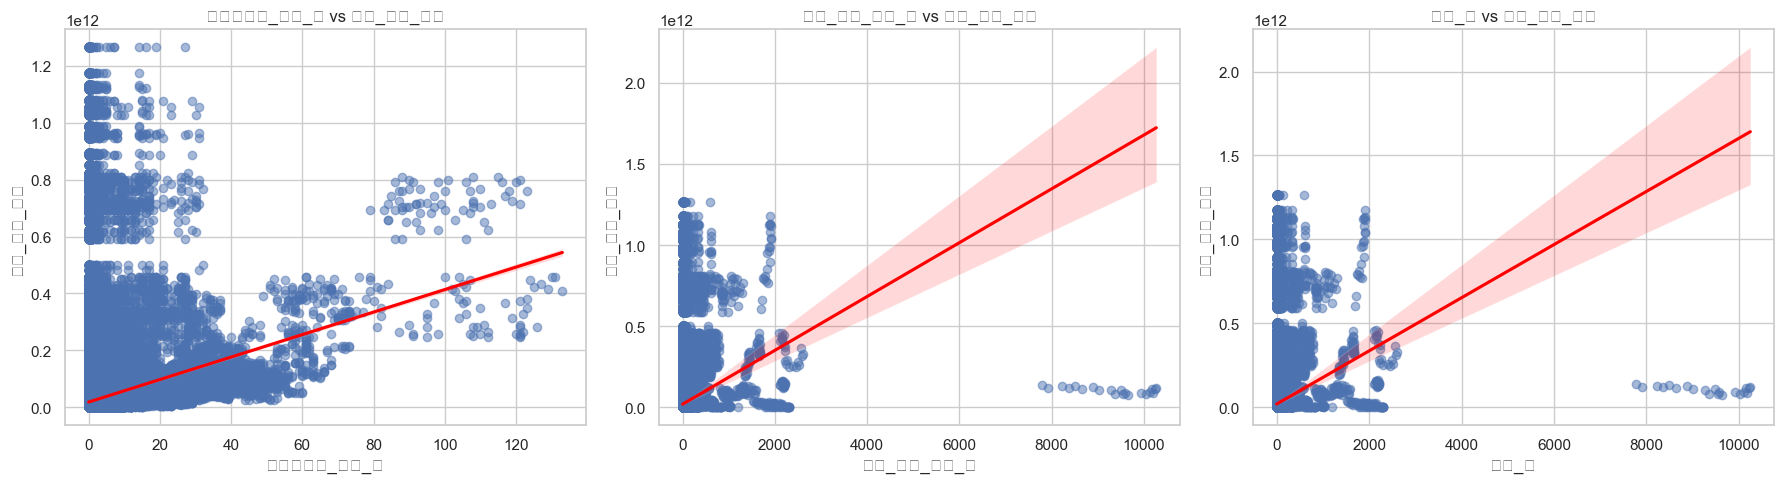

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 결과 파일 로드
output_file = r"C:\Users\m\Downloads\매출-안정성 데이터_병합완료.csv"
df = pd.read_csv(output_file, encoding='utf-8')

# 상관관계가 높은 변수 선택
top_corr_features = ["프랜차이즈_점포_수", "유사_업종_점포_수", "점포_수"]
target = "당월_매출_금액"

# 그래프 스타일 설정
sns.set(style="whitegrid")

# 그래프 그리기
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(top_corr_features):
    sns.regplot(x=df[feature], y=df[target], ax=axes[i], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
    axes[i].set_title(f"{feature} vs {target}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target)

# 그래프 출력
plt.tight_layout()
plt.show()

한글 깨짐 현상 수정

C:\Users\m\AppData\Local\Temp\ipykernel_5540\734797693.py:39: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_5540\734797693.py:39: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_5540\734797693.py:39: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_5540\734797693.py:39: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_5540\734797693.py:39: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_5540\734797693.py:39: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp

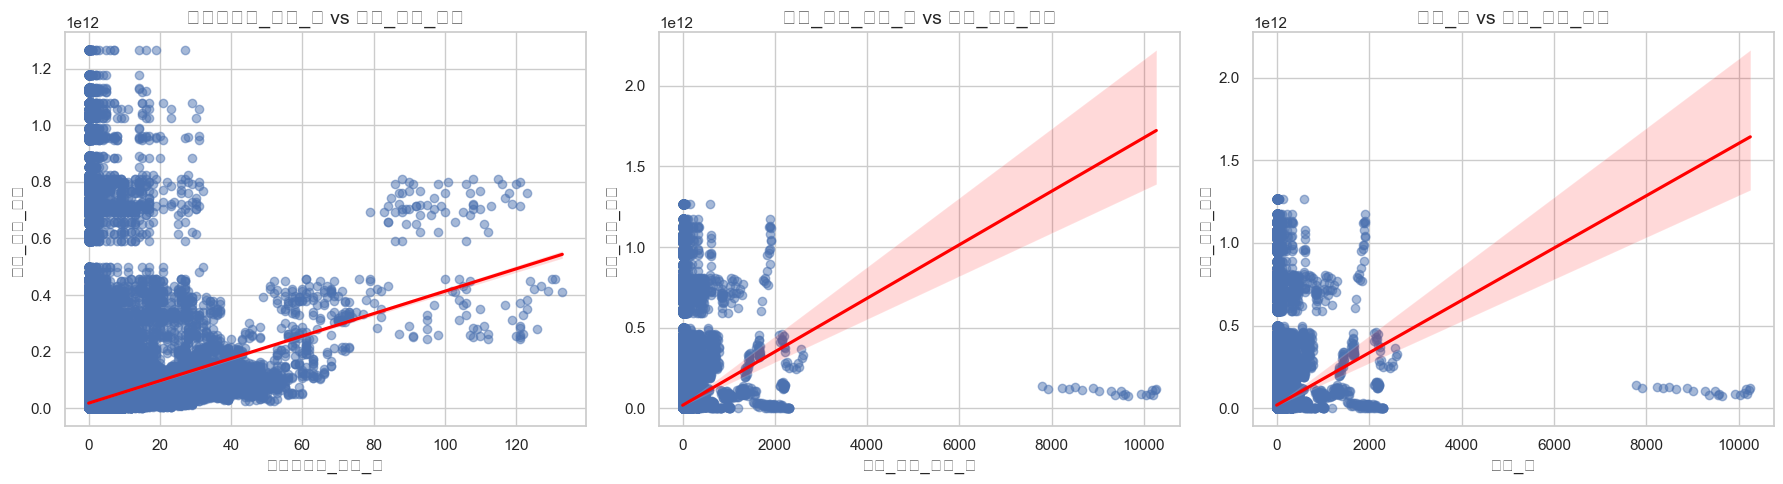

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Matplotlib 한글 폰트 설정
import matplotlib.font_manager as fm
import platform

if platform.system() == "Windows":
    plt.rc("font", family="Malgun Gothic")  # Windows: 'Malgun Gothic' 사용
elif platform.system() == "Darwin":  # macOS
    plt.rc("font", family="AppleGothic")  
else:  # Linux
    plt.rc("font", family="NanumGothic")

plt.rcParams["axes.unicode_minus"] = False  # 음수 부호 깨짐 방지

# 🔹 데이터 로드
output_file = r"C:\Users\m\Downloads\매출-안정성 데이터_병합완료.csv"
df = pd.read_csv(output_file, encoding='utf-8')

# 🔹 상관관계가 높은 변수 선택
top_corr_features = ["프랜차이즈_점포_수", "유사_업종_점포_수", "점포_수"]
target = "당월_매출_금액"

# 🔹 그래프 스타일 설정
sns.set(style="whitegrid")

# 🔹 그래프 그리기
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(top_corr_features):
    sns.regplot(x=df[feature], y=df[target], ax=axes[i], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
    axes[i].set_title(f"{feature} vs {target}", fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel(target, fontsize=12)

# 🔹 그래프 출력
plt.tight_layout()
plt.show()

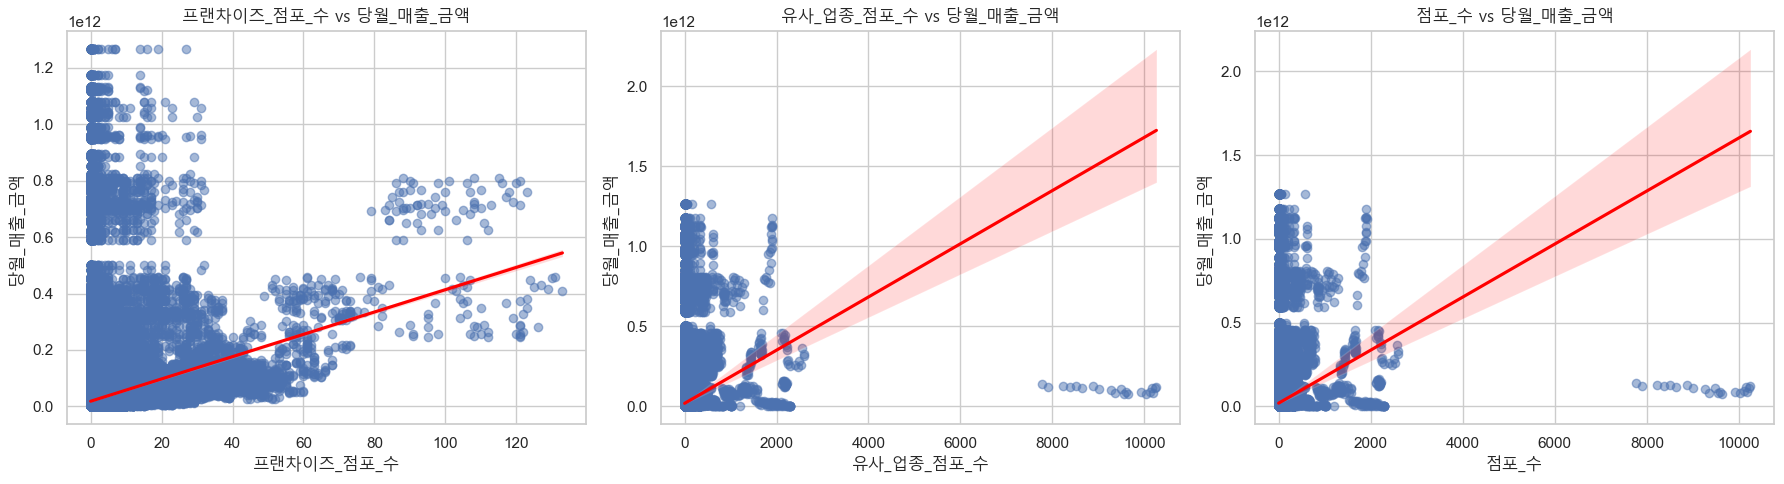

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import platform

# 🔹 한글 폰트 직접 설정
if platform.system() == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows: '맑은 고딕'
elif platform.system() == "Darwin":  # macOS
    font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
else:  # Linux (Colab 포함)
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc("font", family=font_name)
plt.rcParams["axes.unicode_minus"] = False  # 음수 깨짐 방지

# 🔹 데이터 확인
output_file = r"C:\Users\m\Downloads\매출-안정성 데이터_병합완료.csv"
df = pd.read_csv(output_file, encoding='utf-8')

# 🔹 상관관계 높은 변수 선택
top_corr_features = ["프랜차이즈_점포_수", "유사_업종_점포_수", "점포_수"]
target = "당월_매출_금액"

# 🔹 그래프 스타일 지정
sns.set(style="whitegrid")

# 🔹 그래프 그리기
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(top_corr_features):
    sns.regplot(x=df[feature], y=df[target], ax=axes[i], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
    axes[i].set_title(f"{feature} vs {target}", fontsize=14, fontproperties=fm.FontProperties(fname=font_path))
    axes[i].set_xlabel(feature, fontsize=12, fontproperties=fm.FontProperties(fname=font_path))
    axes[i].set_ylabel(target, fontsize=12, fontproperties=fm.FontProperties(fname=font_path))

# 🔹 그래프 출력
plt.tight_layout()
plt.show()